# Setup Nature Modules

## Introduction

<!-- 在这个教程里，我们将创建一个空间框，所有输入的数据都会被自动的重新调整到这个空间范围 -->

Loading an example dataset whose shape is (3 * 4).

<!-- import netCDF4 as nc
import numpy as np
import rasterio
from rasterio.transform import from_origin

# 创建并保存 netCDF 数据
def create_netCDF(filename='example.nc'):
    # 创建一个新的 netCDF 文件
    dataset = nc.Dataset(filename, 'w', format='NETCDF4')

    # 创建维度
    dataset.createDimension('x', 3)
    dataset.createDimension('y', 4)
    dataset.createDimension('time', 5)

    # 创建变量
    times = dataset.createVariable('time', np.int32, ('time',))
    xs = dataset.createVariable('x', np.int32, ('x',))
    ys = dataset.createVariable('y', np.int32, ('y',))
    values = dataset.createVariable('value', np.float32, ('x', 'y', 'time'))

    # 填充数据
    times[:] = range(2015, 2020)  # 填充时间 2015 到 2019
    xs[:] = range(3)  # x 坐标
    ys[:] = range(4)  # y 坐标
    values[:, :, :] = np.random.rand(3, 4, 5)  # 随机数据

    # 关闭文件
    dataset.close()
    return filename

# 创建并保存 TIFF 文件
def create_tiff(base_filename, values):
    tiff_files = []
    # 生成每个时间点的 TIFF 文件
    for i in range(values.shape[2]):
        data = values[:, :, i]
        tiff_filename = f'{base_filename}_time_{i+1}.tif'
        with rasterio.open(
            tiff_filename, 'w', driver='GTiff',
            height=data.shape[0], width=data.shape[1],
            count=1, dtype=str(data.dtype),
            crs='+proj=latlong', transform=from_origin(0, 0, 1, 1)
        ) as dst:
            dst.write(data, 1)
        tiff_files.append(tiff_filename)
    return tiff_files

# 生成 netCDF 文件
nc_file = create_netCDF()

# 读取 netCDF 数据
dataset = nc.Dataset(nc_file, 'r')
values = dataset.variables['value'][:]

# 生成 TIFF 文件
tiff_files = create_tiff('example', values)

# 关闭 netCDF 文件
dataset.close()

nc_file, tiff_files -->


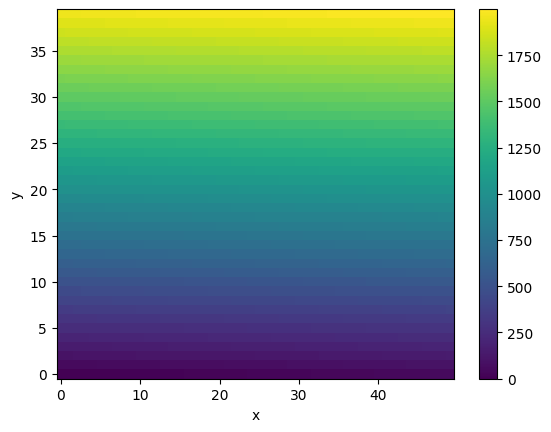

In [1]:
import xarray as xr
import numpy as np


data = xr.DataArray(data=np.arange(2000).reshape((40, 50)), dims=("y", "x"))
data.plot()

Create an `ABSESpy` model with 2 * 2 natural patch module.

In [3]:
from abses import MainModel

model = MainModel()
module = model.nature.create_module("from_resolution", shape=(10, 10))

model.summary()

Using ABSESpy version: v0.5.8


name     MainModel
state         init
tick             0
dtype: object

When apply raster of a `xarray.DataArray` to natural module, the raster will be automatically reprojected to the natural module's spatial extent.

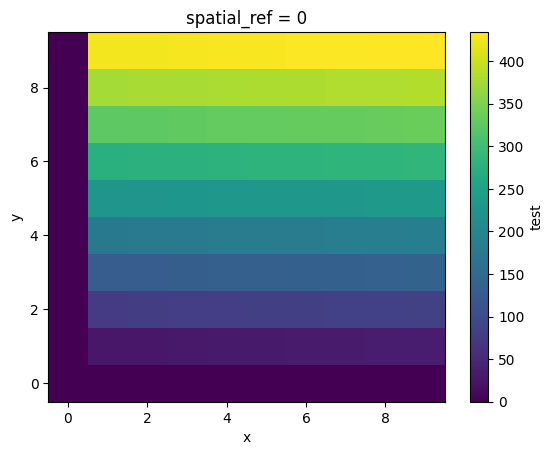

In [4]:
module.apply_raster(
    data, attr_name="test", cover_crs=True, resampling_method="bilinear"
)
ax = module.get_xarray("test").plot()

note: edge effect may exists when re-projecting the raster.

## Working with real data

Here, we have a demo of how to load climate data and apply it to the natural module. When loading the data, the data will be automatically reprojected to the natural module's spatial extent.

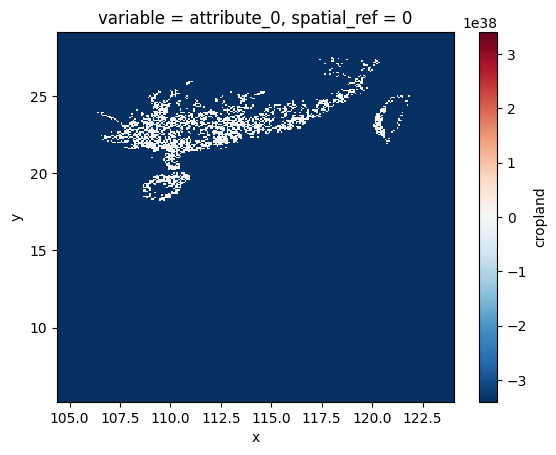

In [8]:
cropland = model.nature.create_module(
    "from_file",
    raster_file="data/farmland.tif",
    flipud=True,
    apply_raster=True,
    name="cropland",
)

cropland.get_xarray().plot()

In [9]:
data = xr.open_dataset("data/precipitation.nc")
data

<xarray.Dataset>
Dimensions:  (lat: 400, lon: 700, time: 12)
Coordinates:
  * lat      (lat) float32 15.05 15.15 15.25 15.35 ... 54.65 54.75 54.85 54.95
  * lon      (lon) float32 70.05 70.15 70.25 70.35 ... 139.6 139.8 139.9 140.0
  * time     (time) datetime64[ns] 2018-01-16T10:30:00 ... 2018-12-16T10:30:00
Data variables:
    prec     (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.0
    history:      Created at 2016-04-02 14:55:55 UTC by the ITPCAS Data Fusio...
    source:       ITPCAS Data Fusion System (Version: 01.02.0240)
    institution:  Institute of Tibetan Plateau Research, Chinese Academy of S...
    title:        Monthly mean precipitation rate from the ITPCAS China Meteo...
    description:  Data from ITPCAS China Meteorological Forcing Dataset (Vers...
    references:   He, J., and K. Yang, 2011: China Meteorological Forcing Dat...

<xarray.Dataset>
Dimensions:  (lat: 400, lon: 700)
Coordinates:
  * lat      (lat) float32 15.05 15.15 15.25 15.35 ... 54.65 54.75 54.85 54.95
  * lon      (lon) float32 70.05 70.15 70.25 70.35 ... 139.6 139.8 139.9 140.0
    time     datetime64[ns] 2018-01-16T10:30:00
Data variables:
    prec     (lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.0
    history:      Created at 2016-04-02 14:55:55 UTC by the ITPCAS Data Fusio...
    source:       ITPCAS Data Fusion System (Version: 01.02.0240)
    institution:  Institute of Tibetan Plateau Research, Chinese Academy of S...
    title:        Monthly mean precipitation rate from the ITPCAS China Meteo...
    description:  Data from ITPCAS China Meteorological Forcing Dataset (Vers...
    references:   He, J., and K. Yang, 2011: China Meteorological Forcing Dat...

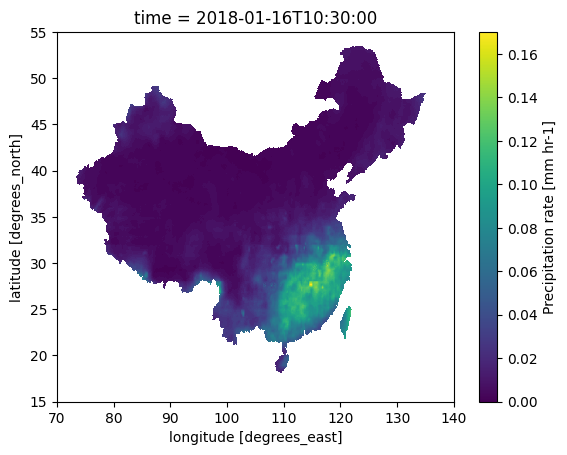

In [10]:
a_month = data.sel(time="2013-01", method="nearest")
a_month["prec"].plot()
a_month

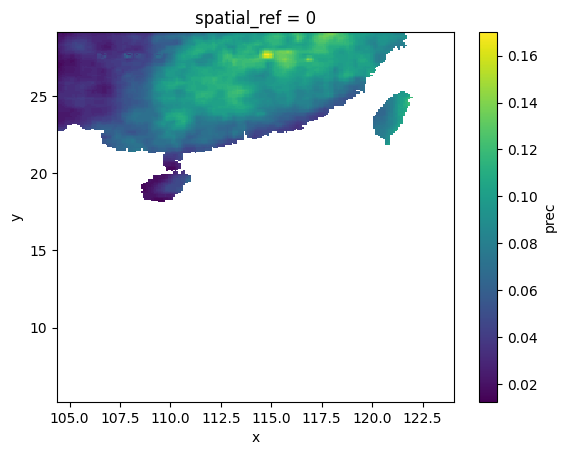

In [11]:
cropland.apply_raster(a_month, attr_name="prec", cover_crs=True)
cropland.get_xarray("prec").plot()